In [2]:
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

import csv
from datetime import datetime, timedelta

## Query sampled data

### Generate datetimes and querys

In [2]:
# Get the 8-15th of each month in 2019; each day 4 timings

year = [2019]
month = list(range(1,13))
day = list(range(8,15))
hour = [8, 12, 18, 00]

In [52]:
query_list = []
for y in year:
    for m in month:
        for d in day:
            for h in hour:
                query_list.append("{}-{:0>2d}-{:0>2d}T{:0>2d}:00:00".format(y, m, d, h))

In [57]:
len(query_list)

336

### Functions from ./src/dataloader.py

In [9]:
def get_weather_data(query:str):
    '''Returns dictionary of JSON objects for weather data given a datetime string
    Each entry in the dictionary is the JSON response for each of the API Endpoints of
     ["air-temperature","rainfall","relative-humidity"]    
    '''
    data_sets = ["air-temperature","rainfall","relative-humidity"]
    results={}
    for measure in data_sets:
        URL = "https://api.data.gov.sg/v1/environment/"+measure
        params={'date_time':query}
        r=requests.get(URL,params=params)
        results[measure]=r.json()
    return results

def get_taxi_data(query:str):
    '''Returns the coordinates of all taxis via the LTA API endpoint for a given datetime string
    '''
    URL = "https://api.data.gov.sg/v1/transport/taxi-availability"
    params={'date_time':query}
    r=requests.get(URL,params=params)
    return r.json()

def assign_taxis(taxi_array:type(np.array),station_array:type(np.array)):
    cartesian_prod = itertools.product(taxi_array,station_array) # Cartesian product for taxi and weather station coordinates
    diff = np.array([i[0]-i[1] for i in cartesian_prod]) 
    distance = np.linalg.norm(diff,axis=1)
    distance_matrix = distance.reshape((len(taxi_array),len(station_array),-1)) # Reshape back into distances since the cartesian product only has one dimension
    return [np.argmin(distance_matrix[i]) for i in range(len(taxi_array))]

def generate_dataset(timestamps:list):
    '''Fetches taxi and weather data for multiple timestamps and returns a dataframe of the data
    '''    

    results=pd.DataFrame(columns=['device_id','latitude','longitude','rainfall','taxis'])

    for timestamp in timestamps:

        weather_data=get_weather_data(query=timestamp)
        taxi_data=get_taxi_data(query=timestamp)

        taxi_coordinates = taxi_data['features'][0]['geometry']['coordinates']
        station_dict = weather_data['rainfall']['metadata']['stations']
        taxi_array = np.array([t[::-1] for t in taxi_coordinates]) # taxi_coordinates are reversed, need to fix
        station_array = np.array([[station_dict[i]['location']['latitude'],station_dict[i]['location']['longitude']] for i in range(len(station_dict))])

        assignment = assign_taxis(taxi_array,station_array)
        assignment_series = pd.Series(assignment)
        assignment_counts = assignment_series.value_counts().sort_index().rename('taxis')

        station_id = [i['id'] for i in station_dict]
        rainfall_array = np.array([i['value'] for i in weather_data['rainfall']['items'][0]['readings']])        

        lat_series = pd.Series(station_array[:,0],name='latitude')
        lon_series = pd.Series(station_array[:,1],name='longitude')
        rainfall_series = pd.Series(rainfall_array,name='rainfall')
        station_id_series = pd.Series(station_id,name='device_id')

        df = pd.concat([station_id_series, lat_series,lon_series,rainfall_series,assignment_counts],axis=1)
        df['timestamp']=query
        results = pd.concat([results,df])
    
    return results

### Request and Save Data

In [78]:
with open('sampled_data.csv', mode='a', newline = '\n') as f:
    write = csv.writer(f)
    write.writerow(['device_id', 'latitude', 'longitude', 'rainfall', 'taxis', 'timestamp'])

for query in query_list:
    results = generate_dataset([query])
    results.to_csv('sampled_data.csv', mode='a', index=False, header=False)

AxisError: axis 1 is out of bounds for array of dimension 1

Potential error: weather & taxi api did not return any available reading.

In [48]:
import datetime

now = datetime.now()
now = str(now)
now = 'T'.join(now[:19].split(' '))
get_taxi_data(now)

{'type': 'FeatureCollection',
 'crs': {'type': 'link',
  'properties': {'href': 'http://spatialreference.org/ref/epsg/4326/ogcwkt/',
   'type': 'ogcwkt'}},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'MultiPoint',
    'coordinates': [[103.62795, 1.30575],
     [103.62829535, 1.28048481666667],
     [103.63531, 1.32676],
     [103.66691, 1.31969],
     [103.67913, 1.30984],
     [103.67927, 1.32684],
     [103.68408, 1.32263],
     [103.6866, 1.34],
     [103.68666, 1.35],
     [103.68735, 1.31302],
     [103.689216, 1.34244383333333],
     [103.6895515, 1.34155766666667],
     [103.69024, 1.34552],
     [103.69066, 1.31491],
     [103.6921, 1.34157],
     [103.69267, 1.34],
     [103.692872433333, 1.34633938333333],
     [103.69432, 1.34],
     [103.69535, 1.34573],
     [103.69537, 1.35],
     [103.696194, 1.334886],
     [103.696213166667, 1.34535883333333],
     [103.6972621, 1.34827161666667],
     [103.69791, 1.34],
     [103.698020166667, 1.33572366666667],
     [10

In [42]:
get_taxi_data('2022-05-22T16:19:00')

{'type': 'FeatureCollection',
 'crs': {'type': 'link',
  'properties': {'href': 'http://spatialreference.org/ref/epsg/4326/ogcwkt/',
   'type': 'ogcwkt'}},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'MultiPoint',
    'coordinates': [[103.63177085, 1.29749848333333],
     [103.63385, 1.32225],
     [103.6364, 1.32105],
     [103.6639, 1.32303],
     [103.6662, 1.32653],
     [103.66642, 1.31235],
     [103.67238, 1.30883],
     [103.67688, 1.3149],
     [103.68661, 1.34],
     [103.688912833333, 1.3415065],
     [103.689362, 1.34254683333333],
     [103.69201, 1.34383],
     [103.69203, 1.34166],
     [103.69267, 1.34],
     [103.692844366667, 1.3463165],
     [103.69336, 1.34],
     [103.69419, 1.3326],
     [103.69432, 1.34],
     [103.69457, 1.34206],
     [103.6948739, 1.33482685],
     [103.69533, 1.35],
     [103.695362516667, 1.34281846666667],
     [103.696187666667, 1.345451],
     [103.6973121, 1.34827661666667],
     [103.69791, 1.34],
     [103.69792, 1.34],
 

In [15]:
query = ['2019-11-09T12:00:00']
w_results = get_weather_data(query)
w_results

{'air-temperature': {'metadata': {'stations': []},
  'items': [{'timestamp': '', 'readings': []}],
  'api_info': {'status': 'healthy'}},
 'rainfall': {'metadata': {'stations': []},
  'items': [{'timestamp': '', 'readings': []}],
  'api_info': {'status': 'healthy'}},
 'relative-humidity': {'metadata': {'stations': []},
  'items': [{'timestamp': '', 'readings': []}],
  'api_info': {'status': 'healthy'}}}

In [17]:
query = ['2019-09-08T08:00:00']
t_results = get_taxi_data(query)
t_results

{'type': 'FeatureCollection',
 'crs': {'type': 'link',
  'properties': {'href': 'http://spatialreference.org/ref/epsg/4326/ogcwkt/',
   'type': 'ogcwkt'}},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'MultiPoint', 'coordinates': []},
   'properties': {'timestamp': '2019-09-08T07:59:32+08:00',
    'taxi_count': 0,
    'api_info': {'status': 'healthy'}}}]}

In [92]:
existing_data = pd.read_csv('sampled_data.csv')

In [105]:
last_date = existing_data['timestamp'][len(existing_data)-1]
for n, d in enumerate(query_list):
    if d == last_date:
        print(n)

223


In [108]:
query_list[223]

'2019-08-14T00:00:00'

In [109]:
query_list[224]

'2019-09-08T08:00:00'

In [111]:
for query in query_list[224:]:
    try:
        results = generate_dataset([query])
        results.to_csv('sampled_data.csv', mode='a', index=False, header=False)
    except:
        print(query)
        continue

2019-09-08T08:00:00
2019-09-10T18:00:00
2019-09-11T18:00:00
2019-11-09T08:00:00
2019-11-09T12:00:00
2019-11-09T18:00:00
2019-11-10T08:00:00
2019-11-10T12:00:00
2019-11-10T18:00:00
2019-11-10T00:00:00
2019-11-11T08:00:00
2019-11-11T12:00:00
2019-11-11T18:00:00
2019-11-11T00:00:00
2019-11-12T08:00:00
2019-11-12T12:00:00
2019-11-12T18:00:00
2019-11-12T00:00:00
2019-11-13T08:00:00
2019-11-13T00:00:00


In [5]:
query1 = ['2019-09-08T08:00:00',
'2019-09-10T18:00:00',
'2019-09-11T18:00:00',
'2019-11-09T08:00:00',
'2019-11-09T12:00:00',
'2019-11-09T18:00:00',
'2019-11-10T08:00:00',
'2019-11-10T12:00:00',
'2019-11-10T18:00:00',
'2019-11-10T00:00:00',
'2019-11-11T08:00:00',
'2019-11-11T12:00:00',
'2019-11-11T18:00:00',
'2019-11-11T00:00:00',
'2019-11-12T08:00:00',
'2019-11-12T12:00:00',
'2019-11-12T18:00:00',
'2019-11-12T00:00:00',
'2019-11-13T08:00:00',
'2019-11-13T00:00:00']

query2 = []
for i in query1:
    dt = datetime.strptime(i, "%Y-%m-%dT%H:%M:%S") + timedelta(hours=1)
    query2.append(dt.strftime("%Y-%m-%dT%H:%M:%S"))

query2

['2019-09-08T09:00:00',
 '2019-09-10T19:00:00',
 '2019-09-11T19:00:00',
 '2019-11-09T09:00:00',
 '2019-11-09T13:00:00',
 '2019-11-09T19:00:00',
 '2019-11-10T09:00:00',
 '2019-11-10T13:00:00',
 '2019-11-10T19:00:00',
 '2019-11-10T01:00:00',
 '2019-11-11T09:00:00',
 '2019-11-11T13:00:00',
 '2019-11-11T19:00:00',
 '2019-11-11T01:00:00',
 '2019-11-12T09:00:00',
 '2019-11-12T13:00:00',
 '2019-11-12T19:00:00',
 '2019-11-12T01:00:00',
 '2019-11-13T09:00:00',
 '2019-11-13T01:00:00']

In [6]:
current_data = pd.read_csv('sampled_data.csv')
current_data

,device_id,latitude,longitude,rainfall,taxis,timestamp
0,S105,1.45817,103.79525,0.0,44.0,2019-01-08T08:00:00
1,S77,1.29370,103.81250,0.0,116.0,2019-01-08T08:00:00
2,S109,1.37640,103.84920,0.0,222.0,2019-01-08T08:00:00
3,S117,1.25600,103.67900,0.0,4.0,2019-01-08T08:00:00
4,S55,1.38370,103.88600,0.0,324.0,2019-01-08T08:00:00
...,...,...,...,...,...,...
15585,S08,1.37010,103.82710,0.2,34.0,2019-12-14T00:00:00
15586,S116,1.28100,103.75400,0.0,7.0,2019-12-14T00:00:00
15587,S104,1.44387,103.78538,0.0,145.0,2019-12-14T00:00:00
15588,S100,1.41720,103.74855,0.0,30.0,2019-12-14T00:00:00


In [8]:
for query in query2:
    results = generate_dataset([query])
    results.to_csv('sampled_data.csv', mode='a', index=False, header=False)

,device_id,latitude,longitude,rainfall,taxis,timestamp


## Explore sampled data

In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import folium

In [14]:
existing_data = pd.read_csv('sampled_data.csv')

In [15]:
existing_data.head()

,device_id,latitude,longitude,rainfall,taxis,timestamp
0,S105,1.45817,103.79525,0.0,44.0,2019-01-08T08:00:00
1,S77,1.29370,103.81250,0.0,116.0,2019-01-08T08:00:00
2,S109,1.37640,103.84920,0.0,222.0,2019-01-08T08:00:00
3,S117,1.25600,103.67900,0.0,4.0,2019-01-08T08:00:00
4,S55,1.38370,103.88600,0.0,324.0,2019-01-08T08:00:00


In [26]:
existing_data['device_id'].nunique()

54

In [16]:
existing_data[['date', 'time']] = existing_data['timestamp'].str.split('T', 1, expand=True)
existing_data.head()

,device_id,latitude,longitude,rainfall,taxis,timestamp,date,time
0,S105,1.45817,103.79525,0.0,44.0,2019-01-08T08:00:00,2019-01-08,08:00:00
1,S77,1.29370,103.81250,0.0,116.0,2019-01-08T08:00:00,2019-01-08,08:00:00
2,S109,1.37640,103.84920,0.0,222.0,2019-01-08T08:00:00,2019-01-08,08:00:00
3,S117,1.25600,103.67900,0.0,4.0,2019-01-08T08:00:00,2019-01-08,08:00:00
4,S55,1.38370,103.88600,0.0,324.0,2019-01-08T08:00:00,2019-01-08,08:00:00


In [17]:
existing_data['date'] = pd.to_datetime(existing_data['date'], format='%Y-%m-%d')

In [18]:
existing_data['time'] = pd.to_datetime(existing_data['time'], format='%H:%M:%S').dt.time

In [19]:
existing_data['dayofweek'] = existing_data['date'].dt.dayofweek
existing_data['dayofweek'] += 1

In [20]:
existing_data

,device_id,latitude,longitude,rainfall,taxis,timestamp,date,time,dayofweek
0,S105,1.45817,103.79525,0.0,44.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
1,S77,1.29370,103.81250,0.0,116.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
2,S109,1.37640,103.84920,0.0,222.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
3,S117,1.25600,103.67900,0.0,4.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
4,S55,1.38370,103.88600,0.0,324.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
...,...,...,...,...,...,...,...,...,...
15585,S08,1.37010,103.82710,0.2,34.0,2019-12-14T00:00:00,2019-12-14,00:00:00,6
15586,S116,1.28100,103.75400,0.0,7.0,2019-12-14T00:00:00,2019-12-14,00:00:00,6
15587,S104,1.44387,103.78538,0.0,145.0,2019-12-14T00:00:00,2019-12-14,00:00:00,6
15588,S100,1.41720,103.74855,0.0,30.0,2019-12-14T00:00:00,2019-12-14,00:00:00,6


#### Weather/Taxi patterns

In [21]:
patterns = existing_data.copy()
patterns.index = patterns.date

In [22]:
patterns.head()

,device_id,latitude,longitude,rainfall,taxis,timestamp,date,time,dayofweek
date,,,,,,,,,
2019-01-08,S105,1.45817,103.79525,0.0,44.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
2019-01-08,S77,1.29370,103.81250,0.0,116.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
2019-01-08,S109,1.37640,103.84920,0.0,222.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
2019-01-08,S117,1.25600,103.67900,0.0,4.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
2019-01-08,S55,1.38370,103.88600,0.0,324.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2


In [37]:
patterns[patterns['rainfall']>0].sort_values('rainfall', ascending=False)

,device_id,latitude,longitude,rainfall,taxis,timestamp,date,time,dayofweek,month_year
date,,,,,,,,,,
2019-11-13,S104,1.44387,103.78538,8.2,28.0,2019-11-13T18:00:00,2019-11-13,18:00:00,3,Nov 2019
2019-11-13,S105,1.45817,103.79525,7.0,10.0,2019-11-13T18:00:00,2019-11-13,18:00:00,3,Nov 2019
2019-03-10,S121,1.37288,103.72244,5.4,19.0,2019-03-10T12:00:00,2019-03-10,12:00:00,7,Mar 2019
2019-06-12,S35,1.33290,103.75560,5.4,202.0,2019-06-12T00:00:00,2019-06-12,00:00:00,3,Jun 2019
2019-06-12,S44,1.34583,103.68166,5.4,69.0,2019-06-12T00:00:00,2019-06-12,00:00:00,3,Jun 2019
...,...,...,...,...,...,...,...,...,...,...
2019-07-09,S82,1.32470,103.63510,0.2,18.0,2019-07-09T08:00:00,2019-07-09,08:00:00,2,Jul 2019
2019-07-09,S100,1.41720,103.74855,0.2,17.0,2019-07-09T08:00:00,2019-07-09,08:00:00,2,Jul 2019
2019-07-09,S91,1.43010,103.83080,0.2,66.0,2019-07-09T12:00:00,2019-07-09,12:00:00,2,Jul 2019


In [34]:
patterns.rainfall.describe()

count    15590.000000
mean         0.013808
std          0.175488
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.200000
Name: rainfall, dtype: float64

In [35]:
print(patterns[patterns.rainfall ==0]['rainfall'].count())
print(patterns[patterns.rainfall ==0]['rainfall'].count()/len(patterns)*100)

15234
97.71648492623477


97.7% of the time has no rain. Perhaps temperature and humidity data needs to come in.

<AxesSubplot:xlabel='date'>

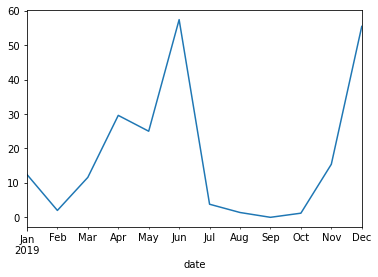

In [36]:
rain_byMonth = patterns.groupby(pd.Grouper(freq='M'))['rainfall'].sum()
rain_byMonth.plot()

In [38]:
rain_byMonth

date
2019-01-31    12.439
2019-02-28     2.000
2019-03-31    11.600
2019-04-30    29.600
2019-05-31    25.000
2019-06-30    57.400
2019-07-31     3.800
2019-08-31     1.400
2019-09-30     0.000
2019-10-31     1.200
2019-11-30    15.400
2019-12-31    55.430
Freq: M, Name: rainfall, dtype: float64

<AxesSubplot:xlabel='time'>

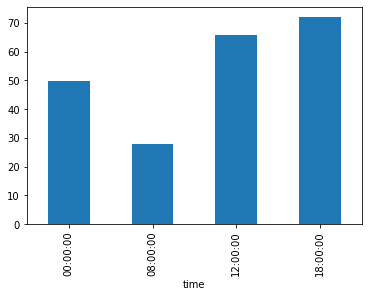

In [39]:
rain_byTime = patterns.groupby('time')['rainfall'].sum()
rain_byTime.plot(kind='bar')

In [40]:
rain_byTime

time
00:00:00    49.803
08:00:00    27.806
12:00:00    65.642
18:00:00    72.018
Name: rainfall, dtype: float64

In [ ]:
## taxi

In [37]:
patterns.taxis.describe()

count    14464.000000
mean        75.415514
std         80.679136
min          1.000000
25%         19.000000
50%         50.000000
75%        105.000000
max        714.000000
Name: taxis, dtype: float64

<AxesSubplot:>

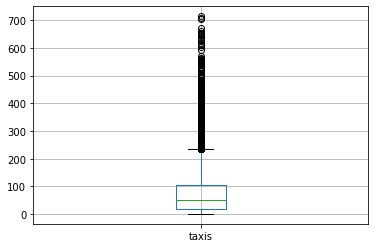

In [41]:
patterns.boxplot(column='taxis')

<AxesSubplot:xlabel='date'>

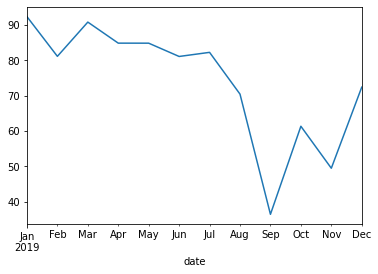

In [42]:
taxi_byMonth = patterns.groupby(pd.Grouper(freq='M'))['taxis'].mean()
taxi_byMonth.plot()

<AxesSubplot:xlabel='dayofweek'>

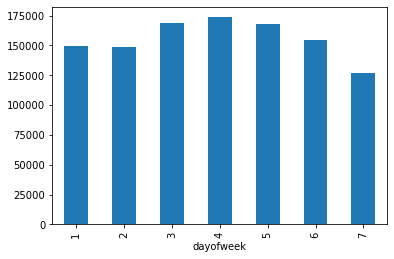

In [43]:
taxi_byDofweek = patterns.groupby('dayofweek')['taxis'].sum()
taxi_byDofweek.plot(kind='bar')

In [44]:
taxi_byDofweek

dayofweek
1    149651.0
2    148658.0
3    168971.0
4    173602.0
5    168419.0
6    154745.0
7    126764.0
Name: taxis, dtype: float64

<AxesSubplot:xlabel='time'>

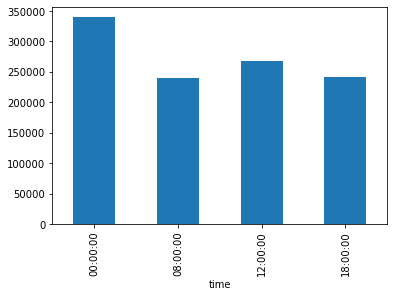

In [45]:
taxi_byTime = patterns.groupby('time')['taxis'].sum()
taxi_byTime.plot(kind='bar')

<AxesSubplot:xlabel='device_id'>

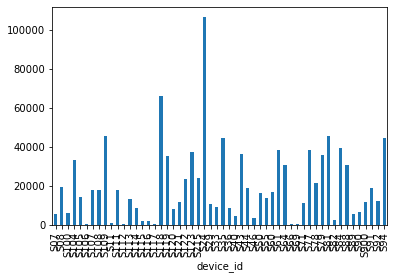

In [46]:
taxi_byArea = patterns.groupby('device_id')['taxis'].sum()
taxi_byArea.plot(kind='bar')

In [11]:
patterns.head()

,device_id,latitude,longitude,rainfall,taxis,timestamp,date,time,dayofweek
date,,,,,,,,,
2019-01-08,S105,1.45817,103.79525,0.0,44.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
2019-01-08,S77,1.29370,103.81250,0.0,116.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
2019-01-08,S109,1.37640,103.84920,0.0,222.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
2019-01-08,S117,1.25600,103.67900,0.0,4.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2
2019-01-08,S55,1.38370,103.88600,0.0,324.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2


C:\Users\User\AppData\Local\Temp/ipykernel_22932/1877482830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timedistr['time'] = timedistr['time'].apply(lambda x: str(x)[:2]).astype(int)


<AxesSubplot:xlabel='dayofweek', ylabel='time'>

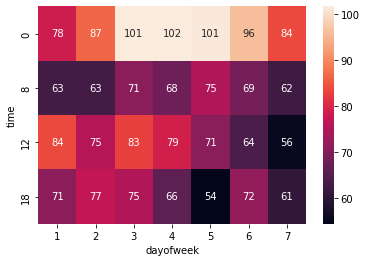

In [46]:
timedistr = patterns[['time', 'dayofweek', 'taxis']]
timedistr['time'] = timedistr['time'].apply(lambda x: str(x)[:2]).astype(int)
# timedistr
sns.heatmap(timedistr.pivot_table(index='time', columns='dayofweek', values='taxis', aggfunc='mean'), 
            annot=True, fmt='.0f')

In [24]:
patterns['month_year'] = patterns['date'].apply(lambda x: x.strftime('%b %Y'))

In [25]:
taxi_byTimeStation = patterns[['device_id', 'month_year', 'taxis']]
taxi_byTimeStation = taxi_byTimeStation.groupby(['month_year', 'device_id'])

,device_id,month_year,taxis
date,,,
2019-01-08,S105,Jan 2019,44.0
2019-01-08,S77,Jan 2019,116.0
2019-01-08,S109,Jan 2019,222.0
2019-01-08,S117,Jan 2019,4.0
2019-01-08,S55,Jan 2019,324.0
...,...,...,...
2019-12-14,S08,Dec 2019,34.0
2019-12-14,S116,Dec 2019,7.0
2019-12-14,S104,Dec 2019,145.0


In [ ]:
sns.lineplot(data=patterns, x="month_year", y="taxis", hue="device_id")

In [133]:
patterns.head()

,device_id,latitude,longitude,rainfall,taxis,timestamp,date,time,dayofweek,rain
date,,,,,,,,,,
2019-01-08,S105,1.45817,103.79525,0.0,44.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2,0
2019-01-08,S77,1.29370,103.81250,0.0,116.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2,0
2019-01-08,S109,1.37640,103.84920,0.0,222.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2,0
2019-01-08,S117,1.25600,103.67900,0.0,4.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2,0
2019-01-08,S55,1.38370,103.88600,0.0,324.0,2019-01-08T08:00:00,2019-01-08,08:00:00,2,0


In [27]:
from branca.element import Figure

In [28]:
device_id = list(existing_data.device_id.unique())
len(device_id)

54

In [29]:
device_loc = {}
for row in range(len(existing_data)):
    if existing_data.device_id[row] not in device_loc.keys():
        device_loc[existing_data.device_id[row]] = [existing_data.latitude[row], existing_data.longitude[row]]
    elif existing_data.device_id[row] in device_loc.keys() and device_loc[existing_data.device_id[row]] == [existing_data.latitude[row], existing_data.longitude[row]]:
        continue
    else:
        print(row, device_id)

In [30]:
sgmap = Figure(width=550,height=350)
m = folium.Map(location=[1.38, 103.8], zoom_start=11)
sgmap.add_child(m)

for k, v in device_loc.items():
    folium.Marker(location=v, popup=k).add_to(m)

m

In [10]:
import geopandas

In [12]:
sg = geopandas.read_file('singapore_map/subzone-census2010-shp/Subzone_Census2010.shp')
sg.head()

,OBJECTID,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area,geometry
0,1,7,MAXWELL,DTSZ07,Y,DOWNTOWN CORE,DT,CENTRAL REGION,CR,5E3B7679E895F85B,2014-05-02,29392.0489,29096.7515,1419.802555,6.366418e+04,"POLYGON ((29537.863 29134.544, 29522.459 29103..."
1,2,1,TANGLIN,ORSZ01,Y,ORCHARD,OR,CENTRAL REGION,CR,3EC2B9D55537C009,2014-05-02,27162.8757,31905.7324,1864.488709,1.675371e+05,"POLYGON ((27418.706 31881.413, 27410.555 31879..."
2,3,2,BOULEVARD,ORSZ02,Y,ORCHARD,OR,CENTRAL REGION,CR,0937E2A5F54A1C53,2014-05-02,27916.9271,31967.0064,4109.231492,4.605504e+05,"POLYGON ((28366.552 31855.703, 28359.125 31841..."
3,4,3,SOMERSET,ORSZ03,Y,ORCHARD,OR,CENTRAL REGION,CR,1C1A0326CE13A8B1,2014-05-02,28626.5610,31494.9048,3039.805140,3.294379e+05,"POLYGON ((28882.434 31681.820, 28882.436 31681..."
4,5,3,PASIR RIS TOWN,PRSZ03,N,PASIR RIS,PR,EAST REGION,ER,37EABA55C9A79089,2014-05-02,40755.8307,39341.7432,5273.291429,1.511612e+06,"POLYGON ((41290.234 39671.558, 41291.480 39656..."
